# P3: Filtering, GTSAM, and Localization

**DUE: Sunday, October 16, 2022**

You'll need to install a new package (inside your class `venv`) for today:
```bash
pip3 install gtsam
```

[Instructions are the same as last time.]

You are *highly recommended* to LaTeX your solutions to this assignment and use the 10pt, 2-column `ieeeconf` template. You can find the template [on Overleaf](https://www.overleaf.com/latex/templates/preparation-of-papers-for-ieee-sponsored-conferences-and-symposia/zfnqfzzzxghk); Overleaf is an online LaTeX editor with a free tier, so feel free to use that service to compose your writeups. It is perhaps the easiest option, particularly if you are not as familiar with LaTeX. While there is no space limit, please try to keep your plots compact so that they do not consume an enormous amount of space; mostly this helps readability (and therefore grading). You are allowed to work in small groups (2 or 3 students), but your solutions and your writeup should be your own.

With these homework assignments, I expect that your solutions will be written as if they are research papers: though the content is not "new", you should be trying to convince me through your writing that you have implemented and understand the algorithms. You should write in full sentences. When appropriate, comment on when the algorithms succeed or fail and where they are more or less effective; include numbers/metrics (quantitative) in addition to discussion (qualitative) whenever possible. Just like in a published paper, you should not include code snippets in your writeup unless it is explicitly asked for or you think it helps you explain your results or answer the question. **I will ask you to submit both the PDF of your writeup *and* a .zip file containing your code (which may be a modified form of this Jupyter notebook) on Blackboard. Unless asked, do not include code in your writeup. You should present your results well enough that I trust your implementation was sufficient.** Though it would be nice if your code were cleaned up and nicely formatted/commented, we will are only likely to run your code to evaluate partial credit or unless we are skeptical for academic integrity reasons.

You are welcome to work in small groups of 2 or 3 students, but please write your solutions independently: I would like your answers to the more conceptual questions to be in your own words, even if you discussed the answers with others.

You will be graded on your included plots and answers to conceptual questions. Your code will not be directly graded or evaluated. You can receive partial credit on pretty much everything, and I try to be a fair as possible: giving you a grade that I think reflects your level of understanding of the material. Note that while I appreciate you submitting plots that you *know* are probably not quite right, it can be hard for me to evaluate partial credit if things are not quite working; in this case, try to include in your response a guess of where you think your solution didn't work. This will help me know when to give you more credit on your responses.


## P3.1 Discrete Filtering & HMMs

## P3.1.1 A simple HMM

I have given you a numpy-based implementation of the example provided in the lectures to get started. You will be using the simple 2-state transition function and observation model to learn more about filtering and the Hidden Markov Model.

**TASK** To start, implement the `predict` and `update` functions following the predict and update functions from lecture.

**TASK** Implement the function `hmm_filter` function, which implements one . I've started it below with the following signature:
```python
def hmm_filter(b0, P_transition, P_obs, observations):
    pass
```

Run the code below to verify that you can generate the first plot (the second two will fail until you complete the next part).

## P3.1.2 Missing some Observations

**QUESTION** (3-4 Sentences) What would happen if you did not receive some observations?

**SKETCH** Draw (by hand or via software) a graphical model corresponding to three steps each with an observation, a step in which no observation was received, and 2 more steps with observations.

**TASK** Extend the HMM Filter to also accept `None` values, which correspond to no observation for that particular step.

**PLOTS** Run the plotting code below and include the plots in your writeup.

**QUESTION** (2-3 Sentences) What happens after receiving multiple `[None]` observations? What values do the probabilities approach (and why)?

In [1]:
# Starter Code 
import numpy as np
import matplotlib.pyplot as plt

b0 = np.array([0.5, 0.5])
P_transition = np.array([
    [0.7, 0.3],
    [0.3, 0.7]
])
P_obs = np.array([
    [0.9, 0.2],
    [0.1, 0.8]
])

assert all(P_transition.sum(axis=0) == 1)
assert all(P_obs.sum(axis=0) == 1)

def predict(b_t_minus_one, P_transition):
    raise NotImplementedError()
    
def update(b_t, P_obs, obs):
    raise NotImplementedError()
    
def hmm_filter(b0, P_transition, P_obs, observations):
    beliefs = [b0]
    bt = b0
    for observation in observations:
        raise NotImplementedError()
        beliefs.append(bt)
        
    return beliefs

In [2]:
# SOLUTION

def predict(b_t_minus_one, P_transition):
    # Prediction Step
    b_t = P_transition @ b_t_minus_one
    return b_t
    
def update(b_t, P_obs, obs):
    # Update Step
    b_t = P_obs[obs] * b_t

    # (Normalize, since its a probability)
    b_t /= b_t.sum()
    
    return b_t

def hmm_filter(b0, P_transition, P_obs, observations):
    beliefs = [b0]
    bt = b0
    for observation in observations:
        bt = predict(bt, P_transition)
        if observation is not None:
            bt = update(bt, P_obs, observation)
        beliefs.append(bt)
    return beliefs

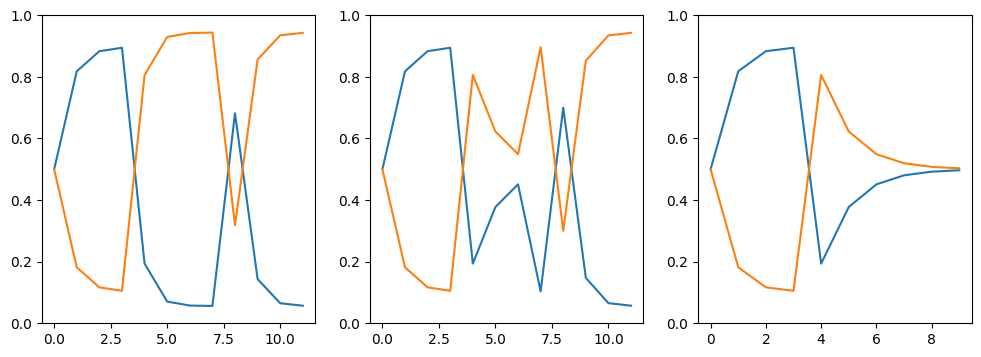

In [3]:

plt.figure(figsize=(12, 4))
plt.subplot(131)
beliefs = hmm_filter(b0, P_transition, P_obs, observations=[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1])
plt.plot(beliefs)
plt.ylim([0, 1])

plt.subplot(132)
beliefs = hmm_filter(b0, P_transition, P_obs, observations=[0, 0, 0, 1, None, None, 1, 0, 1, 1, 1])
plt.plot(beliefs)
plt.ylim([0, 1])

plt.subplot(133)
beliefs = hmm_filter(b0, P_transition, P_obs, observations=[0, 0, 0, 1, None, None, None, None, None])
plt.plot(beliefs)
plt.ylim([0, 1])

None

## P3.2 The Kalman Filter

Now you're going to reproduce the results I showed you from class (admittedly with a different random seed).

> *Note*: You are recommended to do this question before P3.3, which builds on some of these concepts using GTSAM.

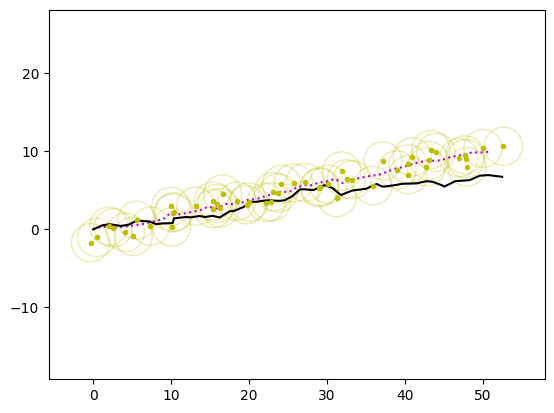

In [4]:
# Example Data: GPS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

def plot_point2_on_axes(axes, point, P=None):
    axes.plot([point[0]], [point[1]], marker='.', markersize=10)
    if P is not None:
        w, v = np.linalg.eigh(P)
        # this corresponds to 95%
        k = 2.447746830681

        angle = np.arctan2(v[1, 0], v[0, 0])
        e1 = patches.Ellipse(point,
                             np.sqrt(w[0]) * 2 * k,
                             np.sqrt(w[1]) * 2 * k,
                             np.rad2deg(angle),
                             fill=False,
                             alpha=0.3)
        axes.add_patch(e1)


def get_noisy_gps_data_p3(do_plot=False):
    np.random.seed(1234)
    steps = 50
    std = 0.2

    # Robot moving generally rightward
    dx_true = np.random.normal(1.0, 0.2, size=[steps])
    dy_true = np.random.normal(0.2, 0.2, size=[steps])

    dx_noisy = dx_true + np.random.normal(0.0, 0.3, size=[steps])
    dy_noisy = dy_true + np.random.normal(0.0, 0.3, size=[steps])

    x_true = np.cumsum(np.concatenate(([0], dx_true), axis=0))
    y_true = np.cumsum(np.concatenate(([0], dy_true), axis=0))
                    
    x_gps = np.cumsum(np.concatenate(([0], dx_true), axis=0)) \
        + np.random.normal(0.0, 1.0, size=[steps + 1])
    y_gps = np.cumsum(np.concatenate(([0], dy_true), axis=0)) \
        + np.random.normal(0.0, 1.0, size=[steps + 1])
    
    if do_plot:
        plt.plot(x_true, y_true, ':m')
        plt.plot(np.cumsum(np.concatenate(([0], dx_noisy), axis=0)), 
                 np.cumsum(np.concatenate(([0], dy_noisy), axis=0)), '-k')
        plt.plot(x_gps, y_gps, '.y')
        for x, y in zip(x_gps, y_gps):
            k = 2.447746830681
            w = [1, 1]
            e1 = patches.Ellipse([x, y],
                             np.sqrt(w[0]) * 2 * k,
                             np.sqrt(w[1]) * 2 * k,
                             0,
                             fill=False,
                             alpha=0.3,
                             color='y')
            plt.gca().add_patch(e1)

        plt.axis('equal')

    return x_true, y_true, dx_noisy, dy_noisy, x_gps, y_gps

x_true, y_true, dx_noisy, dy_noisy, x_gps, y_gps = get_noisy_gps_data_p3(do_plot=True)
None

**TASK** Implement the `kalman_filter` function below, using what we discussed in class. Note that we don't have a "control" in the same way the equations discuss, and so both $A_t$ and $C_t$ do not exist (treat them as the identity) and the "control input" $\mu_t$ is just the observed motion of the robot (the noisy `dx` and `dy`). I leave it to you to figure out the remaining terms. Also, note that I have provided a toggle to control whether the "update" step is performed. Without GPS, the covariance should grow without bound

**CODE** Include your completed `kalman_filter` function in your writeup.

**PLOTS** Run the plotting code below to see the results of both using and not using the GPS.

In [5]:
# Starter Code:
# Kalman Filter

initial_position = np.array([0.0, 0.0])
cov_prior = np.diag([0.01, 0.01])
cov_motion = np.diag([0.09, 0.09])
cov_gps = np.diag([1, 1])

pos = initial_position
cov = cov_prior


def kalman_filter(x0, y0, cov_prior, 
                  dx_noisy, dy_noisy, x_gps, y_gps,
                  do_use_gps=True):
    positions = [[x0, y0]]
    covariances = [cov_prior]

    for (dx, dy, xg, yg) in zip(dx_noisy, dy_noisy, x_gps, y_gps):
        # Prediction
        raise NotImplementedError("Prediction Step")
    
        if do_use_gps:
            # Update Step
            raise NotImplementedError("Update Step")
    
    return positions, covariances

In [6]:
# SOLUTION

def kalman_filter(x0, y0, cov_prior, 
                  dx_noisy, dy_noisy, x_gps, y_gps,
                  do_use_gps=True):
    positions = [[x0, y0]]
    covariances = [cov_prior]

    for (dx, dy, xg, yg) in zip(dx_noisy, dy_noisy, x_gps, y_gps):
        # Prediction
        pos = positions[-1] + np.array([dx, dy])
        cov = covariances[-1] + cov_motion
    
        if do_use_gps:
            # Update Step
            K = cov * np.linalg.inv(cov + cov_gps)
            pos = pos + K @ ([xg, yg] - pos) 
            cov = (np.eye(2) - K) @ cov
            
        positions.append(pos)
        covariances.append(cov)
    
    return positions, covariances

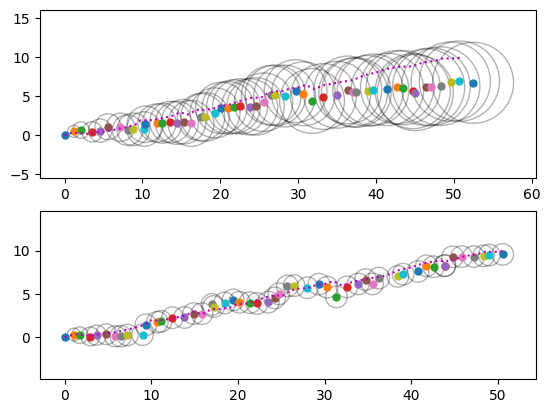

In [7]:
# Resulst and plotting
plt.figure()

plt.subplot(211)
ax = plt.gca()
positions, covariances = kalman_filter(
    0, 0, cov_prior, dx_noisy, dy_noisy, x_gps, y_gps, False)
for pos, cov in zip(positions, covariances):
    plot_point2_on_axes(ax, pos.copy(), cov.copy())
plt.plot(x_true, y_true, ':m')
plt.axis('equal')

plt.subplot(212)
ax = plt.gca()
positions, covariances = kalman_filter(
    0, 0, cov_prior, dx_noisy, dy_noisy, x_gps, y_gps, True)
for pos, cov in zip(positions, covariances):
    plot_point2_on_axes(ax, pos.copy(), cov.copy())
plt.plot(x_true, y_true, ':m')
plt.axis('equal')
None

## P3.3 GTSAM

The Georgia Tech Smoothing and Mapping (GTSAM) package is a fantastic library for solving factor graphs, including those of the type we have discussed in class. Next, you'll play around with the python `gtsam` package and implement some interesting scenarios that you would likely have trouble solving "by hand" as you did for the previous two questions.

### P3.3.1 GSTAM Fundamentals

First, you'll run through some simple GTSAM code and observe the results; in fact, this is much the same code we went through in our breakout session during lecture L06.

**PLOT** Run the code below and include the resulting plot in your writeup. In the absence of any GPS signal, noise compounds whenever the robot moves and you should notice that the error grows more and more as you move.

**TASK** Add a GPS signal! At point `6`, the GPS tells you that the robot is at point `(10.02, 0.0)`. To include this, add a `PriorFactorPoint2` for this point `6` with the GPS noise model `GPS_NOISE`.

**PLOT** Rerun the plotting code and include the result (with the GPS) in your report.

**QUESTION** (3-6 Sentences) What happens to the covariances? In particular, comment on what happens to the covariance elipse at point 5 (and why)?

In [8]:
import gtsam
import gtsam.utils.plot as gtsam_plot

def print_result_point2(result):
    for key in result.keys():
        print(f"Point[{key}]:\n"
              f"  Location: {result.atPoint2(key)}, \n"
              f"  Covariance: \n{marginals.marginalCovariance(key)}\n" )

def plot_result_point2(result):
    ax = plt.gca()
    for key in result.keys():
        plot_point2_on_axes(ax, result.atPoint2(key), marginals.marginalCovariance(key))
    
    plt.axis('equal')
    plt.show()

In [9]:
# Example adapted from the officaial examples:
#  https://github.com/borglab/gtsam/tree/develop/python/gtsam/examples

# Create noise models
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3], dtype=float))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3], dtype=float))
GPS_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.05, 0.05], dtype=float))

# 1. Create a factor graph container
graph = gtsam.NonlinearFactorGraph()

# 2a. Add a prior: that the robot starts at the origin.
# A prior factor consists of a mean and a noise PRIOR_NOISE (covariance matrix)
graph.add(gtsam.PriorFactorPoint2(1, gtsam.Point2(0, 0), PRIOR_NOISE))

# 2b. Add odometry factors
# NOTE: you can do this with for loops as well!
# Create odometry (Between) factors between consecutive poses
graph.add(gtsam.BetweenFactorPoint2(
    1, 2, gtsam.Point2(2, 0), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPoint2(
    2, 3, gtsam.Point2(2, 0), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPoint2(
    3, 4, gtsam.Point2(2, 0), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPoint2(
    4, 5, gtsam.Point2(2, 0), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPoint2(
    5, 6, gtsam.Point2(2, 0), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPoint2(
    6, 7, gtsam.Point2(2, 0), ODOMETRY_NOISE))

# 2c. Add a 'GPS' observation
# TOOD: this is something you will do!

In [10]:
# SOLUTION:
graph.add(gtsam.PriorFactorPoint2(6, gtsam.Point2(10.02, 0), GPS_NOISE))

Point[1]:
  Location: [0.00331797 0.        ], 
  Covariance: 
[[0.07506912 0.        ]
 [0.         0.07506912]]

Point[2]:
  Location: [2.00663594 0.        ], 
  Covariance: 
[[0.1202765 0.       ]
 [0.        0.1202765]]

Point[3]:
  Location: [ 4.00995392e+00 -3.08148791e-33], 
  Covariance: 
[[0.13562212 0.        ]
 [0.         0.13562212]]

Point[4]:
  Location: [ 6.01327189e+00 -3.08148791e-33], 
  Covariance: 
[[0.12110599 0.        ]
 [0.         0.12110599]]

Point[5]:
  Location: [ 8.01658986e+00 -3.08148791e-33], 
  Covariance: 
[[0.07672811 0.        ]
 [0.         0.07672811]]

Point[6]:
  Location: [10.01990783  0.        ], 
  Covariance: 
[[0.00248848 0.        ]
 [0.         0.00248848]]

Point[7]:
  Location: [1.20199078e+01 3.08148791e-33], 
  Covariance: 
[[0.09248848 0.        ]
 [0.         0.09248848]]



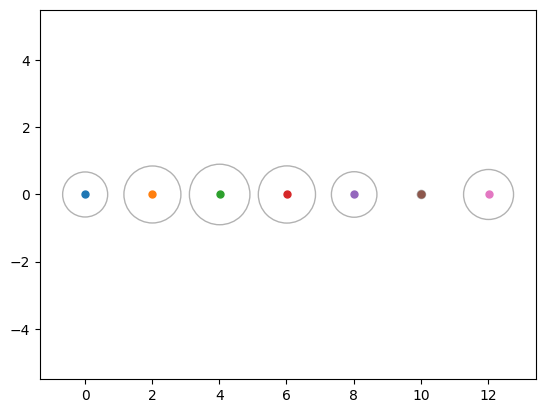

In [11]:
# 3. Create the data structure to hold the initial_estimate estimate to the
# solution. For illustrative purposes, these have been deliberately set to incorrect values
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Point2(0.5, 0.0))
initial_estimate.insert(2, gtsam.Point2(2.3, 0.1))
initial_estimate.insert(3, gtsam.Point2(4.1, 0.1))
initial_estimate.insert(4, gtsam.Point2(6.0, 0.0))
initial_estimate.insert(5, gtsam.Point2(8.1, 0.1))
initial_estimate.insert(6, gtsam.Point2(10.0, 0.1))
initial_estimate.insert(7, gtsam.Point2(11.9, 0.1))

# 4. Optimize the initial values using a Gauss-Newton nonlinear optimizer
# The optimizer accepts an optional set of configuration parameters,
# controlling things like convergence criteria, the type of linear
# system solver to use, and the amount of information displayed during
# optimization. We will set a few parameters as a demonstration.
parameters = gtsam.GaussNewtonParams()

# Stop iterating once the change in error between steps is less than this value
parameters.setRelativeErrorTol(1e-5)
# Do not perform more than N iteration steps
parameters.setMaxIterations(100)
# Create the optimizer ...
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
# ... and optimize
result = optimizer.optimize()

# 5. Calculate marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)

# 6. Printing and Plotting
print_result_point2(result)
plot_result_point2(result)

### 3.3.2 GTSAM Version of 3.2 Example

Now we'll revisit the example from P3.2 above, but this time we'll implement it in GTSAM.

**TASK** Use GTSAM to build a factor graph using the noisy GPS data from P3.2 (I've reproduced it in the block of code below.) I have provided you with only minimal code, so use what you have seen from P3.3.1 to complete the implementation.

**PLOT** Run the plotting code below that shows the GTSAM example.

**QUESTION** (5-8 sentences) You may notice that the GTSAM example is *quite* similar to your Kalman filter example, but will be slightly different. Describe how they are similar and different. Why are there differences? What is GTSAM doing that the Kalman filter example does not?

In [12]:
# Starter code and noise definitions.

import gtsam

# Create noise models
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1], dtype=float))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3], dtype=float))
GPS_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([1.0, 1.0], dtype=float))

x_true, y_true, dx_noisy, dy_noisy, x_gps, y_gps = get_noisy_gps_data_p3(do_plot=False)

graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

graph.add(gtsam.PriorFactorPoint2(0, gtsam.Point2(0, 0), PRIOR_NOISE))

# Now you do the rest!

In [13]:
# SOLUTION
# Example adapted from the official examples:
#  https://github.com/borglab/gtsam/tree/develop/python/gtsam/examples

# Add the odometry factors
for ii, (dx, dy) in enumerate(zip(dx_noisy, dy_noisy)):
    graph.add(gtsam.BetweenFactorPoint2(ii, ii+1, gtsam.Point2(dx, dy), ODOMETRY_NOISE))

# Set the initial estimates
x_noisy = np.cumsum(np.concatenate(([0], dx_noisy), axis=0))
y_noisy = np.cumsum(np.concatenate(([0], dy_noisy), axis=0))
for ii, (x, y) in enumerate(zip(x_noisy, y_noisy)):
    initial_estimate.insert(ii, gtsam.Point2(x, y))

# Add 'GPS' observations
for ii, (x, y) in enumerate(zip(x_gps, y_gps)):
    graph.add(gtsam.PriorFactorPoint2(ii, gtsam.Point2(x, y), GPS_NOISE))

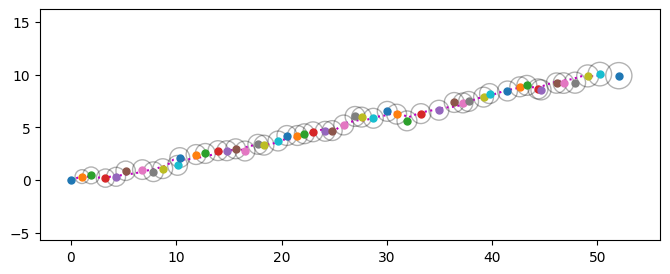

In [14]:
# Parameters for the optimization
parameters = gtsam.GaussNewtonParams()
parameters.setRelativeErrorTol(1e-5)
parameters.setMaxIterations(100)
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
result = optimizer.optimize()
marginals = gtsam.Marginals(graph, result)

# Printing and Plotting
plt.figure(figsize=(8, 3))
plt.plot(x_true, y_true, ':m')
# print_result_point2(result)
plot_result_point2(result)

### 3.3.3 GTSAM for Differential Drive

In the previous example, we used a motion model that was purely gaussian, and so we could implement it ourselves using the Kalman filter. Next, we'll use the Differential Drive robot, but a noisy one, with noisy wheels and odometry estimates. Here, the robot has both position and yaw (orientation). As such, position is not enough and we cannot use `gtsam.Point2`; instead we need `gtsam.Pose2`. Use `gtsam.BetweenFactorPose2`, `gtsam.PriorFactorPose2`, and `gtsam.Pose2` to implement the factor graph for this robot using the partial function below.

**TASK** Finish implementing `compute_updated_states`

**PLOT** Run the plotting code below and include them in your report.

**QUESTION** (4-8 Sentences) Describe what you see both without the GPS and with it. Without the GPS, what happens to the covariance matrices? Why are they not "circular" as they have been?

In [15]:
# Starter Code: Noisy Differential Drive Robot

import numpy as np
import matplotlib.pyplot as plt

# Inspired by: https://w3.cs.jmu.edu/molloykp/teaching/cs354/cs354_2021Fall/resources/pid.pdf
# Some equations from: https://www.cs.columbia.edu/~allen/F17/NOTES/icckinematics.pdf


class NoisyDiffDrive(object):
    def __init__(self, width=0.1, wheel_err=0.015, max_spin=1,
                 pos_err=0.15, angle_err=0.05, gps_err=0.3):
        self.start_pos_x = 0
        self.start_pos_y = 0
        self.start_theta = 0
        self.pos_x = self.start_pos_x
        self.pos_y = self.start_pos_y
        self.theta = self.start_theta
        self.width = 0.1
        self.max_spin = max_spin
        self.vel = 0
        self.wheel_err = wheel_err
        self.actual_poses = []
        
        # Measurements and errors
        self.observations = [{
            'raw_pose': [self.start_pos_x, self.start_pos_y, self.start_theta],
            'motion': None, 
            'gps': None}]
        self.pos_err = pos_err
        self.angle_err = angle_err
        self.gps_err = gps_err
        
        self.true_states = [[self.pos_x, self.pos_y, self.theta]]
        
    def get_noisy_state(self):
        return self.observations[-1]['raw_pose']
    
    def drive(self, vl, vr, dt=1):
        vel = np.sqrt(vl*vl + vr*vr)
        if vel > self.max_spin:
            vl /= vel
            vr /= vel
        
        # The wheels are quite "noisy"
        self.vl = vl + np.random.normal(0.0, self.wheel_err)
        self.vr = vr + np.random.normal(0.0, self.wheel_err)
        
        # Move the robot and update the state
        oth = self.theta
        dx, dy, dth = self._advance_time(dt)
        
        # The motion measurement is corrupted
        old_raw_pose = self.observations[-1]['raw_pose']
        rel_motion = [
            dx * np.cos(oth) + dy * np.sin(oth) + np.random.normal(0.0, self.pos_err),
            dx * np.sin(-oth) + dy * np.cos(oth) + np.random.normal(0.0, self.pos_err),
            dth + np.random.normal(0.0, self.angle_err)
        ]
        dxr, dyr, dthr = rel_motion
        othr = old_raw_pose[2]
        raw_pose = [
            old_raw_pose[0] + dxr * np.cos(othr) - dyr * np.sin(othr), 
            old_raw_pose[1] + dxr * np.sin(othr) + dyr * np.cos(othr), 
            old_raw_pose[2] + dthr
        ]
        
        if np.random.rand() < 0.2:
            gps = [
                self.pos_x + np.random.normal(0.0, self.gps_err),
                self.pos_y + np.random.normal(0.0, self.gps_err),
                self.theta + np.random.normal(0.0, self.angle_err)
            ]
        else:
            gps = None

        observation = {
            'raw_pose': raw_pose,
            'motion': rel_motion,
            'gps': gps
        }
        self.observations.append(observation)
        # self.vel += u
        return observation
        
    def _advance_time(self, dt):
        
        old_state = {
            'x': self.pos_x, 
            'y': self.pos_y, 
            'theta': self.theta
        }
        
        if np.abs(self.vr - self.vl) < 0.0001:
            # Robot moves in a straight line
            self.pos_x += self.vr * dt * np.cos(self.theta)
            self.pos_y += self.vr * dt * np.sin(self.theta)
            self.true_states.append([self.pos_x, self.pos_y, self.theta])
            return [self.pos_x - old_state['x'],
                    self.pos_y - old_state['y'],
                    self.theta - old_state['theta']]
        
        R = self.width / 2 * (self.vl + self.vr) / (self.vr - self.vl)
        omega = (self.vr - self.vl) / self.width
        
        ICCx = self.pos_x - R * np.sin(self.theta)
        ICCy = self.pos_y + R * np.cos(self.theta)
        
        domega = omega * dt

        updated_state = np.array([
            [np.cos(domega), -np.sin(domega), 0],
            [np.sin(domega), np.cos(domega), 0],
            [0, 0, 1]
        ]) @ np.array([
            [self.pos_x - ICCx],
            [self.pos_y - ICCy],
            [self.theta]
        ]) + np.array([
            [ICCx],
            [ICCy],
            [domega]
        ])

        self.pos_x = updated_state[0, 0]
        self.pos_y = updated_state[1, 0]
        self.theta = updated_state[2, 0]
        
        self.true_states.append([self.pos_x, self.pos_y, self.theta])
        return [self.pos_x - old_state['x'],
                self.pos_y - old_state['y'],
                self.theta - old_state['theta']]
        
    def visualize_trajectory(self):
        points = np.array(self.true_states)
        plt.plot(points[:, 0], points[:, 1], ':m')
        points = np.array([obs['raw_pose'][:2] for obs in self.observations])
        plt.plot(points[:, 0], points[:, 1], 'k')
        plt.gca().set_aspect('equal', adjustable='box')


In [16]:
# Function to compute the "smoothed" state of the robot

def compute_updated_states(robot, do_use_gps=True):
    observations = robot.observations
    
    # Create noise models
    PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1], dtype=float))
    ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.15, 0.1, 0.05], dtype=float))
    GPS_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.4, 0.4, 0.1], dtype=float))

    # Initializations
    graph = gtsam.NonlinearFactorGraph()
    initial_estimate = gtsam.Values()

    # Prior
    initial_pose = observations[0]['raw_pose']
    graph.add(gtsam.PriorFactorPose2(0, 
        gtsam.Pose2(initial_pose[0], initial_pose[1], initial_pose[2]), PRIOR_NOISE))

    # Odometry and Initial Estimates
    for ii, observation in enumerate(observations):
        raw_pose = observation['raw_pose']
        raise NotImplementedError("Add the initial estimate for each pose.")
        
        initial_estimate.insert(ii, gtsam.Pose2(raw_pose[0], raw_pose[1], raw_pose[2]))
        if observation['motion'] is not None:
            motion = observation['motion']
            raise NotImplementedError("Add the motion between poses.")
        
        if do_use_gps and observation['gps'] is not None:
            gps = observation['gps']
            # NOTE: the 'GPS' also has angle (for simplicity)
            raise NotImplementedError("Add the 'GPS' (as a 'prior factor pose2').")

    # Optimize the initial values using a Gauss-Newton nonlinear optimizer
    parameters = gtsam.GaussNewtonParams()
    parameters.setRelativeErrorTol(1e-5)
    parameters.setMaxIterations(100)
    optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
    result = optimizer.optimize()
    marginals = gtsam.Marginals(graph, result)
    
    # Get the outputs
    last_key = result.keys()[-1]
    last_pose2 = result.atPose2(last_key)
    last_state = [last_pose2.x, last_pose2.y, last_pose2.theta]
    return last_state, result, marginals

In [17]:
# SOLUTION: 

def compute_updated_states(robot, do_use_gps=True):
    observations = robot.observations
    
    # Create noise models
    PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1], dtype=float))
    ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.15, 0.1, 0.05], dtype=float))
    GPS_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.4, 0.4, 0.1], dtype=float))

    # Initializations
    graph = gtsam.NonlinearFactorGraph()
    initial_estimate = gtsam.Values()

    # Prior
    initial_pose = observations[0]['raw_pose']
    graph.add(gtsam.PriorFactorPose2(0, 
        gtsam.Pose2(initial_pose[0], initial_pose[1], initial_pose[2]), PRIOR_NOISE))

    # Odometry and Initial Estimates
    for ii, observation in enumerate(observations):
        raw_pose = observation['raw_pose']
        initial_estimate.insert(ii, gtsam.Pose2(raw_pose[0], raw_pose[1], raw_pose[2]))
        if observation['motion'] is not None:
            motion = observation['motion']
            graph.add(gtsam.BetweenFactorPose2(ii-1, ii, 
                gtsam.Pose2(motion[0], motion[1], motion[2]), ODOMETRY_NOISE))
        
        if do_use_gps and observation['gps'] is not None:
            gps = observation['gps']
            graph.add(gtsam.PriorFactorPose2(ii,
                gtsam.Pose2(gps[0], gps[1], gps[2]), GPS_NOISE))

    # Optimize the initial values using a Gauss-Newton nonlinear optimizer
    parameters = gtsam.GaussNewtonParams()
    parameters.setRelativeErrorTol(1e-5)
    parameters.setMaxIterations(100)
    optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
    result = optimizer.optimize()
    marginals = gtsam.Marginals(graph, result)
    
    # Get the outputs
    last_key = result.keys()[-1]
    last_pose2 = result.atPose2(last_key)
    last_state = [last_pose2.x(), last_pose2.y(), last_pose2.theta()]
    return last_state, result, marginals

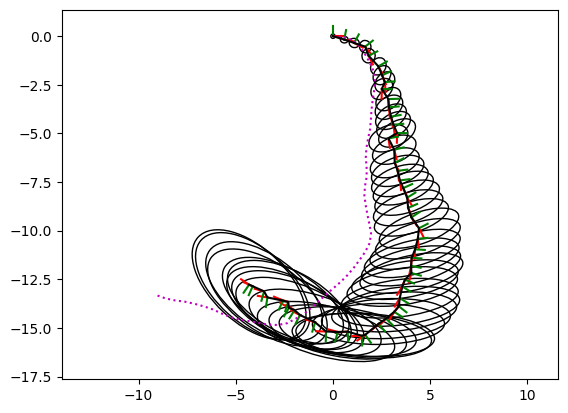

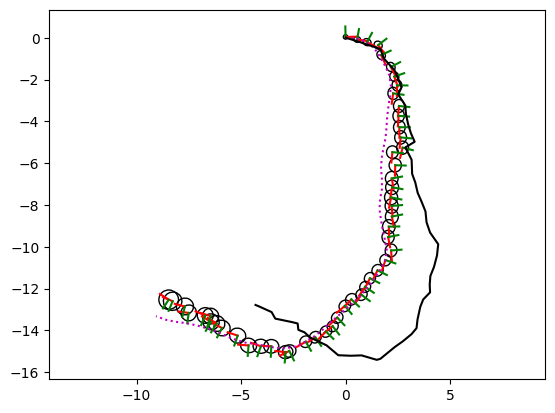

In [18]:
# Results & Plotting

## === First is the No GPS version ===
np.random.seed(685)
num_steps = 50
robot = NoisyDiffDrive()
for _ in range(num_steps):
    robot.drive(0.5, 0.5)

last_state, result, marginals = compute_updated_states(robot, do_use_gps=False)

fig = plt.figure(0)
for key in result.keys():
    gtsam_plot.plot_pose2_on_axes(plt.gca(), result.atPose2(key), 0.5, 
                                  marginals.marginalCovariance(key))

robot.visualize_trajectory()
plt.axis('equal')
plt.show()

## === Next is the With GPS version ===

np.random.seed(685)
num_steps = 50
robot = NoisyDiffDrive()
for _ in range(num_steps):
    robot.drive(0.5, 0.5)

last_state, result, marginals = compute_updated_states(robot, do_use_gps=True)

fig = plt.figure(0)
for key in result.keys():
    gtsam_plot.plot_pose2_on_axes(plt.gca(), result.atPose2(key), 0.5, 
                                  marginals.marginalCovariance(key))

robot.visualize_trajectory()
plt.axis('equal')
plt.show()

### P3.3.4 Filtering and a Controller

I have provided you with a stub of a `simple_diff_drive_controller` function. The point of this function is to drive in the direction of the goal.

**TASK+PLOT** Complete this function with your implemetation of the simple diff drive controller from P1 (you may also use mine if you'd like; see the solution for P1). Run the results code below. You should see that the *black* line heads towards the goal on the right. This means that the robot is not *actually* at the goal, which you can see in the dashed magenta line.

**TASK+PLOT** Use your `compute_updated_states` to compute the true robot state using the motion and GPS measurements at each step. Update your controller below to use this filtered state estimate for the controller instead. Your robot should reach the goal (see the dashed magenta line).

You can see how important this might be: if the robot were not using the additional information provided by the GPS, it would not be able to reliably reach its goal.

In [19]:
# Controller 
np.random.seed(685)

def simple_diff_drive_controller(robot, gx, gy, K_theta, K_vel, dt=1.0):
    # gx is the goal x position
    # gy is the goal y position

    for _ in range(500):
        # Use the "noisy state" to start
        rstate = robot.get_noisy_state()
        x_pos = rstate[0]
        y_pos = rstate[1]
        yaw = rstate[2]
        
        vl = None
        vr = None
        raise NotImplementedError()

        robot.drive(vl, vr)
        if dist < 1:
            break

In [20]:
# SOLUTION

def simple_diff_drive_controller(robot, gx, gy, K_theta, K_vel, dt=1.0):
    # gx is the goal x position
    # gy is the goal y position

    for _ in range(500):
        rstate = robot.get_noisy_state()
        rstate, _, _ = compute_updated_states(robot, do_use_gps=True)
        theta_rel = np.arctan2(gy - rstate[1], gx - rstate[0]) - rstate[2]
        theta_rel = theta_rel % (2 * np.pi)
        if theta_rel > np.pi:
            theta_rel -= 2 * np.pi
            
        dist = np.sqrt(
            (gy - rstate[1]) ** 2 + (gx - rstate[0]) ** 2
        )

        vl = K_vel * dist - K_theta * theta_rel
        vr = K_vel * dist + K_theta * theta_rel

        robot.drive(vl, vr)
        if dist < 1:
            break

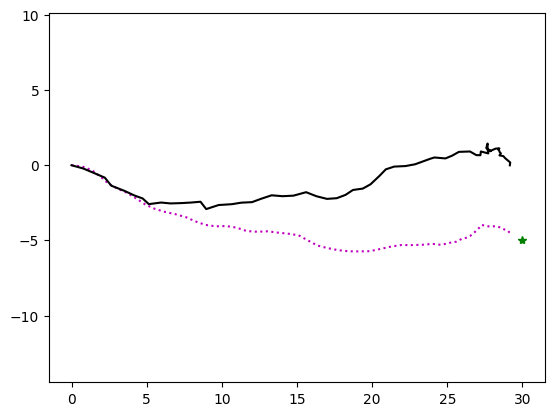

In [21]:
# Results and plotting

robot = NoisyDiffDrive()
gx = 30
gy = -5

# NOTE: Feel free to change the values of the K parameters
simple_diff_drive_controller(robot, gx=gx, gy=gy, K_theta=0.1, K_vel=0.1)

robot.visualize_trajectory()
plt.plot([gx], [gy], 'g*')
plt.axis('equal')
plt.show()

## P3.4 Particle Filter Localization

In this question, we'll localize a robot using laser scan observations. Run the code below the view the map that we'll be working with as well as the `gridmap.laser.simulate_sensor_measurement` that you'll use to simulate the laser scan in the map:

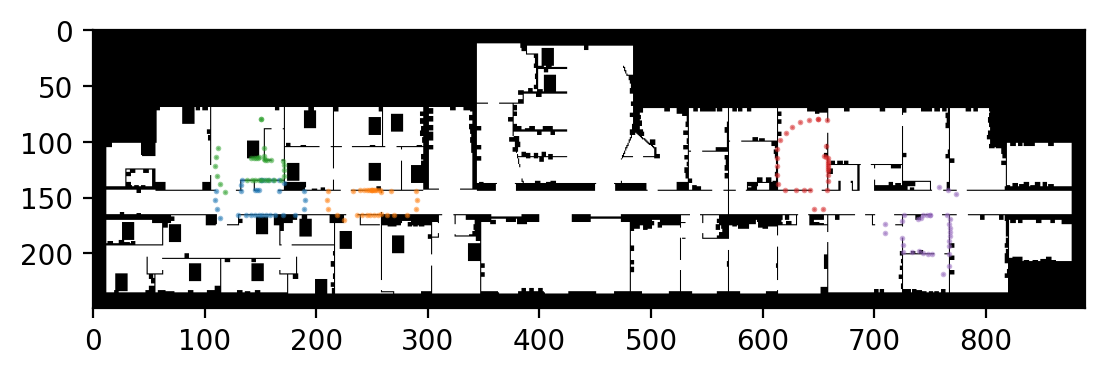

In [22]:
import gridmap
from common import Pose
import matplotlib.pyplot as plt
import numpy as np
import pickle

def view_scan(directions, ranges, pose):
    upoints = ranges * directions
    yaw = pose.yaw
    xs = (upoints[0] * np.cos(yaw) 
          + upoints[1] * np.sin(yaw) 
          + pose.x)
    ys = (upoints[0] * np.sin(-yaw) 
          + upoints[1] * np.cos(yaw) 
          + pose.y)
    plt.plot(ys, xs, '.', markersize=2, alpha=0.5)
    

map_data = pickle.load(open("6-1_1254_data.pickle", "rb"))
grid = map_data['occ_grid'].T


num_laser_points = 32
max_laser_range = 40
directions = gridmap.laser.get_laser_scanner_directions(num_laser_points, 2*np.pi)


plt.figure(dpi=200)
plt.imshow(1-grid, cmap='gray')
example_poses = [
    Pose(150, 150, 0),
    Pose(150, 250, 0),
    Pose(120, 150, 0),
    Pose(120, 650, 0),
    Pose(180, 750, 0),
]
for pose in example_poses:
    ranges = gridmap.laser.simulate_sensor_measurement(
        grid, directions, max_laser_range, pose)
    view_scan(directions, ranges, pose)

### P3.4.1 Designing an Observation Model

Before we can localize the robot, we need an observation model that will tell us the likelhood of getting a particular sensor measurement versus the "true" measurement. 

Each laser scan is given as a list of floats. Each element of the scan . We call this vector the "ranges" since each point gives us the distance (or range) to the obstacles in that direction.

We'll keep the observation model fairly simple for this assignment: we will compare the "true scan", the "observed ranges" generated by the robot itself and the "simulated ranges" that correspond to ranges that we generate from hypotential robot poses. By comparing the two, we will be able to tell how "good" that hypothetical pose is based on what we've seen so far.

**TASK** Complete the `def prob_of_scan(observed_ranges, simulated_ranges, sigma=20)` function below. The likelihood of each point should be given by a gaussian distribution of std-dev sigma:

$$ p(r_o, r_s) = \exp(- (r_o - r_s)^2 / \sigma^2) $$

You should compare the range for each of the pairs between the scans: the first range in the first scan with the first range of the second, and so on. The total likelihood is thus the product of the individual likelhoods for all pairs. 

**RESULT** Run the "results" code below and include the results in your writeup. You should see that the likelihood of the "true" pose is very good and decreases for scans that look completely different. Sanity check your results against the scans generated in the code block above.

In [23]:
# Starter Code
def prob_of_scan(observed_ranges, simulated_ranges, sigma=25):
    raise NotImplementedError()

In [24]:
## SOLUTION
def prob_of_scan(observed_ranges, simulated_ranges, sigma=25):
    return np.prod(np.exp(-(observed_ranges - simulated_ranges)**2 / (sigma ** 2)))

In [25]:
# Results
true_pose = Pose(150, 150, 0)
observed_ranges = gridmap.laser.simulate_sensor_measurement(
    grid, directions, max_laser_range, true_pose)
sim_poses = [
    Pose(150, 150, 0),
    Pose(152, 150, 0),
    Pose(150, 250, 0),
    Pose(120, 650, 0),
    Pose(180, 750, 0),
]
for pose in sim_poses:
    sim_ranges = gridmap.laser.simulate_sensor_measurement(
        grid, directions, max_laser_range, pose)
    print(f"For Pose {pose}: likelihood={prob_of_scan(observed_ranges, sim_ranges)}")

For Pose <Pose x:150.000000, y:150.000000, yaw:0.000000>: likelihood=1.0
For Pose <Pose x:152.000000, y:150.000000, yaw:0.000000>: likelihood=0.7271630967664442
For Pose <Pose x:150.000000, y:250.000000, yaw:0.000000>: likelihood=0.14781360172693395
For Pose <Pose x:120.000000, y:650.000000, yaw:0.000000>: likelihood=2.0218034737932523e-09
For Pose <Pose x:180.000000, y:750.000000, yaw:0.000000>: likelihood=0.0002618020154242193


### P3.4.2 Computing Particles

Next, we will want to initialize a set of particles. I have provided you with a `Particle` class for you to use. You are asked to complete two functions:

**TASK** Complete `initialize_particles`, as defined below. Create a set of `num_particles` Particles, each with a random starting pose (and fixed probability). Feel free to use `get_random_pose` for this function, as it will give you a random pose in the grid that does not intersect any obstacles.

**TASK** Complete the `move_robot_and_update_particles` function. This function first moves the robot and generates a scan (observation). It then moves each of the particles using `particle.move` and the known motion of the robot and updates the weight of each of the particles using the `prob_of_scan` function you used above.

**PLOT** Run the plotting code below and include the result in your writeup. The brightness of each point corresponds to its likelihood. You should see bright spots in the hallway, since those measurements are similar to the observed scan from the true robot pose.

> Note: colors of the particles are shown on a log scale for clarity

In [26]:
# Starter Code

class Particle(object):
    def __init__(self, pose, prob):
        self.x = pose.x
        self.y = pose.y
        self.yaw = pose.yaw
        self.prob = prob
        
    def get_pose(self):
        return Pose(self.x, self.y, self.yaw)

    def move(self, dx, dy, dyaw, pos_sigma=2, yaw_sigma=0):
        self.x += dx + np.random.normal(0.0, pos_sigma)
        self.y += dy + np.random.normal(0.0, pos_sigma)
        self.yaw += dyaw + np.random.normal(0.0, yaw_sigma)

    
def visualize_particles(particles, do_use_log_scale=False):
    xs = [p.x for p in particles]
    ys = [p.y for p in particles]
    probs = [p.prob for p in particles]
    if do_use_log_scale:
        plt.scatter(ys, xs, s=2, c=np.log(probs))
    else:
        plt.scatter(ys, xs, s=2, c=probs)


def get_random_pose(grid, num_attempts=1000):
    for _ in range(num_attempts):
        xr = np.random.rand() * grid.shape[0]
        yr = np.random.rand() * grid.shape[1]
        if grid[int(xr), int(yr)] < 1:
            yawr = 0 * np.random.rand() * 2 * np.pi
            return Pose(xr, yr, yawr)


def initialize_particles(num_particles=5000):
    particles = []
    for _ in range(num_particles):
        raise NotImplementedError()


def move_robot_and_update_particles(
        robot_pose, particles, dx, dy, dyaw):
    # Move the robot
    robot_pose.x += dx
    robot_pose.y += dy
    robot_pose.yaw += dyaw
    
    # Get the robot observation
    observed_ranges = gridmap.laser.simulate_sensor_measurement(
        grid, directions, max_laser_range, robot_pose)
    
    # Move the particles and update their "weights" 
    # (stored as 'prob' in the class I have provided)
    raise NotImplementedError()

In [27]:
## SOLUTION

def initialize_particles(num_particles=5000):
    particles = []
    for _ in range(num_particles):
        pose = get_random_pose(grid)
        sim_ranges = gridmap.laser.simulate_sensor_measurement(
            grid, directions, max_laser_range, pose)
        prob = prob_of_scan(ranges, sim_ranges)
        particles.append(Particle(pose, prob))
    
    return particles

def move_robot_and_update_particles(
        robot_pose, particles, dx, dy, dyaw):
    # Move the robot
    robot_pose.x += dx
    robot_pose.y += dy
    robot_pose.yaw += dyaw
    
    # Get the robot observation
    ranges = gridmap.laser.simulate_sensor_measurement(
        grid, directions, max_laser_range, robot_pose)
    
    # Move the particles and update the probabilities
    for particle in particles:
        particle.move(dx, dy, dyaw)
        sim_ranges = gridmap.laser.simulate_sensor_measurement(
            grid, directions, max_laser_range, particle.get_pose())
        prob = prob_of_scan(ranges, sim_ranges)
        particle.prob *= prob

In [28]:
## Results

robot_pose = Pose(150, 150, 0)
particles = initialize_particles()
move_robot_and_update_particles(
    robot_pose, particles, dx=0, dy=0, dyaw=0)

plt.figure(dpi=200)
plt.imshow(1-grid, cmap='gray')
visualize_particles(particles, do_use_log_scale=False)

plt.figure(dpi=200)
plt.imshow(1-grid, cmap='gray')
visualize_particles(particles, do_use_log_scale=True)

### P3.4.3 Resampling and Localizing

Finally, we will implement the resampling function that we use . Follow the discussion from the lecture slides to implement this function. In short, you want to sample a new set of particles using the weights you computed in the last step. 

As an example, let's say you have 5 particles with weights [0.8, 0.19, 0.01, 0.00, 0.00]. You sample 5 values from that weighted distribution and get [0, 1, 0, 0, 1]. This means that of your five new particles: three of them will have the pose of the original Particle 0, two will have the pose of the original Particle 1, and none corresponding to the other three. The "prob" of each will be 0.2 (they are all equal).

**TASK** Implement the `resample_particles` function below using the procedure described above. You may find `np.random.choice` helpful for this purpose, as it's designed to generate random integers according to a weighted probability distribution.

**PLOTS** Run the "results" code below and include the plots in your writeup. It might take a minute or two to run.

**QUESTION** (2-5 sentences) What is the "results" code doing? How is the robot moving. Is our particle filter converging on the right positions over time?


In [29]:
# Starter Code
def resample_particles(particles):
    raise NotImplementedError()


In [30]:
## SOLUTION

def resample_particles(particles):
    pdf = [p.prob for p in particles]
    pdf /= sum([p.prob for p in particles])
    n_inv = 1/len(particles)
    u = np.random.rand() * n_inv
    
    choices = np.random.choice(np.arange(len(particles)), 
                               size=len(particles),
                               p=pdf)
    new_particles = [Particle(particles[c].get_pose(), n_inv) 
                     for c in choices]
    return new_particles


<Pose x:150.000000, y:190.000000, yaw:0.000000>
<Pose x:150.000000, y:230.000000, yaw:0.000000>
<Pose x:150.000000, y:270.000000, yaw:0.000000>
<Pose x:150.000000, y:310.000000, yaw:0.000000>


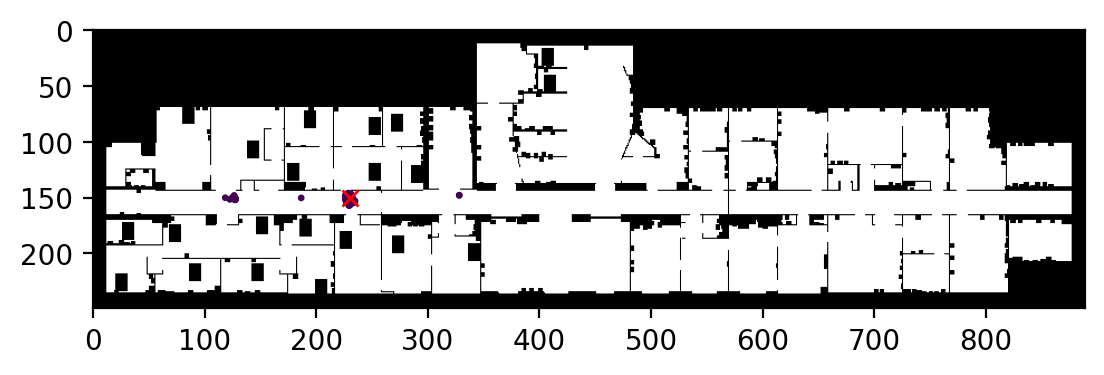

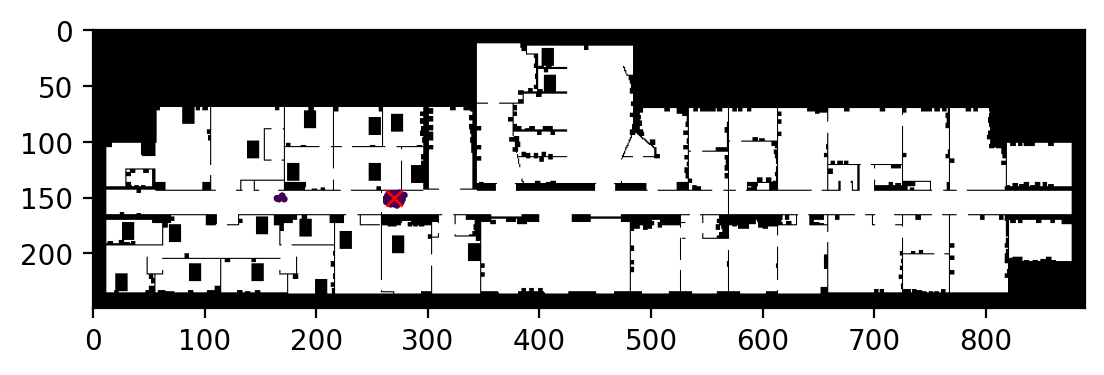

In [31]:
# Results & plotting

particles = initialize_particles()
robot_pose = Pose(150, 150, 0)

for _ in range(4):
    move_robot_and_update_particles(
            robot_pose, particles, dx=0, dy=40, dyaw=0)
    particles = resample_particles(particles)

    print(robot_pose)
    plt.figure(dpi=200)
    plt.imshow(1-grid, cmap='gray')
    visualize_particles(particles)
    plt.plot([robot_pose.y], [robot_pose.x], 'xr')